In [1]:
!pip uninstall -y torch
!pip install torch==2.0.1 torchtext==0.15.2

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.4 MB/s eta 0:00:00


In [2]:
!pip install -Uqq portalocker>=2.0.0
!pip install -qq torchtext
!pip install -qq torchdata
!pip install -Uqq plotly
!pip install -qq dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 21.2 MB/s eta 0:00:00


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# TOKENIZADOR

In [19]:
train_iter= iter(AG_NEWS(split="train"))

In [33]:
y,text= next((train_iter))
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [6]:
# obtenemos el tokenizador
tokenizer = get_tokenizer("basic_english")

#función yield, para tokenizar
def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

#Construimos el vocabulario y le decimos que ajuste por defecto unk para no dar error
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# OBTENEMOS EL DATASET

In [7]:
# Spliteamos en train y test, en este caso ag_news() te entrega directamente dos iteradores
train_iter, test_iter = AG_NEWS()

# SE CONVIERTEN EN MAP STYLE, QUE ES TIPO PANDAS, LOS CARGA TODOS EN MEMORIA, NO COMO LOS ITERADORES QUE SOLO
# CARGAN UN DATO CADA VEZ, PERO COMO EL SET ES PEQUEÑO NO TENEMOS PROBLEMAS
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# DENIMOS LA CANTIDAD DE DATOS QUE TENDREMOS EN TRAIN YA QUE DIVIDIMOS EL TRAIN EN TRAIN Y VALIDATION.
num_train = int(len(train_dataset) * 0.95)


# MEZCLAREMOS RANDOMENTE LSO DATOS, POR ESO USAMOS RANDOM_SPLIT
# LE METES LA CANTIDAD DE DATOS DEL PRIMERO Y LA CANTIDAD DE DATOS DEL SEGUNDO
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [8]:
# VEMOS SI TENEMOS GPU DISPONIBLE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# DATA LOADER

In [9]:
# funciones de texto
# lo que hace la primera es que te la tokeniza y luego la transforma a numeros con vocab
def text_pipeline(x):
  return vocab(tokenizer(x))

# esta función lo que hace es sacar la etiqueta de x si, se asegura de pasarlo a entero y quitarle uno
# tipo los índices porque python empieza contando en 0
def label_pipeline(x):
   return int(x) - 1

In [10]:
# DEFINIMOS LA FUNCIÓN DE COLLATE

def collate_batch(batch):
    # lista de etiquetas, lista de texto, offsets
    # OFFSETS es el índice donde empieza la frase. Es decir la frase 0 empieza en 0, pero si la primera tiene 5 palabras, pues el segundo
    # término de offsets, será 0+5 palabras. Sería pues 6. Dice que la segunda frase empieza en índice de text_list 6, porque
    # guarda todas las lsitas de palabras juntas text_list
    label_list, text_list, offsets = [], [], [0]

    # ITERAMOS SOBRE ETIQUETA Y TEXTO EN EL BATCH
    for _label, _text in batch:

        # añadimos la etiqueta a la lista de etiquetas, usando la funcion extrae etiquetas
        label_list.append(label_pipeline(_label))

        # aquí lo que hace es llamar a la función text_pipeline la procesa y la hace tensor
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text) # lo añade a la lista

        # AÑADE EL ÍNDICE QUE HEMOS DICHO A OFFSET
        offsets.append(processed_text.size(0))

    # PASAMOS A TENSORES
    label_list = torch.tensor(label_list, dtype=torch.int64) # Etiquetas a tensores
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)   # Calcula la suma acumulativa para determinar los índices iniciales de cada texto concatenado.
    text_list = torch.cat(text_list)  # Creamos un solo tensor contínuo
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [11]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

# CREACIÓN DE RED NEURONAL

In [12]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):   # es la funcion que se ejecuta automáticamente al llamar a la clase(llamas a la clase con eso lleno)
        # tamaño del vocab, dimension de los embedings y número de clases
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False) # capa de embeddings, mapea cada palabra a un vector tamaño embed_dim(eleccion libre)

        # Almacen a la capa lineal del modelo. Convierte la predicción en salidas
        # tantas salidas posibles como clases
        self.fc = nn.Linear(embed_dim, num_class)
        # Aquí llamamos a la inicialización de los pesos
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange) # los inicia entre 0.5 y -0.5
        self.fc.weight.data.uniform_(-initrange, initrange)  #para que no sean igualos los distribuye de forma normal
        self.fc.bias.data.zero_() # inicializa el sesgo en 0

    def forward(self, text, offsets): # El método forward define como los datos pasan por el modelo, cuando se usa modelo(datos) pasan por aquí
        # Calcula primero con embbeded los embeddings del texto que se le ha pasado
        embedded = self.embedding(text, offsets)

        # pasa los embeddings por la capa lineal de arriba, lo que se obtiene una salida de tamaño num_class
        # la salida es sin aplicar softmax
        return self.fc(embedded)

In [14]:
vocab_size=len(vocab)
vocab_size

95811

In [15]:
emsize=64

In [20]:
#num_class=len(set([label for (label, text) in train_iter]))
num_class=4

In [21]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

# CREACIÓN DEL PREDICTOR Y EVALUADOR

In [22]:
# FUNCIÓN QUE PREDICE:

def predict(text, text_pipeline):
    with torch.no_grad(): # al ser una predicción no se usa el cálculo de gradientes
        text = torch.tensor(text_pipeline(text)).to(device) # lo transforma a según el vocabulario y lo hace tensor

        offset1=torch.tensor([0]).to(device) # crea un tensor de 0
        output = model(text, offset1) # llama al modelo y te da el return (por eso le pasas texto y tensor)
        return ag_news_label[output.argmax(1).item() + 1]

In [23]:
def evaluate(dataloader): # recibe un data loader, ya sea el de test o validación

    model.eval() # ponemos el modelo en modo evaluación
    total_acc, total_count= 0, 0 # iniciamos los contadores de predicciones correctas y de ejemplos evaluados

    with torch.no_grad(): # desactivamos el gradiente ya que no estamos entrenando

        # iteramos sobre el data loader, etiqueta, texto y offset
        for idx, (label, text, offsets) in enumerate(dataloader):
            # sacamos la predicción
            predicted_label = model(text, offsets)

            # con el argmax, saca la clase predicha y la compara con la verdadera
            total_acc += (predicted_label.argmax(1) == label).sum().item() # si coincide suma 1
            total_count += label.size(0) #coincida o no coincida suma uno aquí
    return total_acc / total_count

# ENTRENAMIENTO DEL MODELO

In [24]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss() # selecciona el criterio de la función d eperdida
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # lo optimiza con lo que sea con lr
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1) # va variando el lr para no caer en minimos locales

In [25]:
# PARÁMETROS INICIALES
EPOCHS = 30
cum_loss_list=[] # pérdida total por epoch
acc_epoch=[] # precisión de la epoch
acc_old=0  # mejor precisión hasta el momento

for epoch in tqdm(range(1, EPOCHS + 1)): # hacemos cada época y con tqdm nos muestra el progreso de cada epoch

    model.train()  # activamos el modo train del modelo
    cum_loss=0 # iniciamos la perdida en 0

    # recorremos los datos generados por el train_dataloader
    for idx, (label, text, offsets) in enumerate(train_dataloader):

        optimizer.zero_grad() # limpiamos los gradientes acumulados
        predicted_label = model(text, offsets) # realiza la predicción del modelo

        loss = criterion(predicted_label, label) # compara las predicciones con las etiquetas verdaderas

        loss.backward() # realiza backpropagation y calcula los gradiente de la función de perdida

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # limita los valores para que no exploten

        optimizer.step()  # actualiza los parámetros usando el optimizador seleccionado y los gradientes calculados
        cum_loss+=loss.item() # Va acumulando la pérdida


    # Guardamos métricas de la época
    cum_loss_list.append(cum_loss)

    # EVALUACIÓN EN EL SET DE VALIDACIÓN
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val) # guarda la precisión en la lista

    # si es mejor que la epoch anterior, pues guarda el modelo y el valor de accuracy
    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 30/30 [04:59<00:00, 10.00s/it]


# EVALUACIÓN

In [27]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

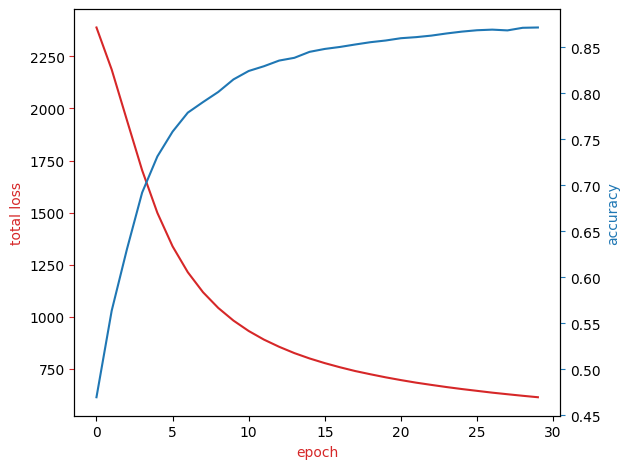

In [28]:
plot(cum_loss_list,acc_epoch)

In [29]:
evaluate(test_dataloader)

0.8709210526315789

# PRUEBA DEL FUNCIONAMIENTO

In [30]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [34]:
result = predict(article, text_pipeline)
print(f"Resultado: {result}")


Resultado: Sports
